# plotHCR_LDR-noise
Used this script to help determine the power return likely to be the threshold between noise and legit returns. Plots the histogram of DBMHX and then prints the DBM of the peak. From there, we eyeballed a value to the right of the peak where the distribution has mostly leveled off. We can then mask LDR on this value and plot before and after plots for a given period of time to evaluate.
<br><br>
<font color='blue'>DBMHX threshold for SOCRATES chosen to be **-101.0 dBm** _(based on evaluations of multiple flights)_</font>
<br><br>
_Written by Dan Stechman_
<br>
_University of Illinois at Urbana-Champaign_

In [1]:
import pyart
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
import xarray as xr
import datetime
import matplotlib.dates as mdates
import os

dt = datetime.datetime

warnings.filterwarnings("ignore",category=RuntimeWarning)

np.set_printoptions(suppress=True)
%matplotlib inline 

In [2]:
# flight = 'RF06_20180129'
# startT = '20180129_051500'
# endT = '20180129_053000'

# flight = 'RF03_20180123'
# startT = '20180122_224500'
# endT = '20180122_230000'

flight = 'RF02_20180119'
startT = '20180119_043000'
endT = '20180119_044500'

hcrFile = '/Volumes/SOCRATES_1/' + flight + '/HCR/' + flight + '_concat-HCR-moments.nc'

In [3]:
hcrData = xr.open_dataset(hcrFile)

time1d = np.asarray(hcrData['time1d'].data,dtype='datetime64[ns]')
time1d_rnd = (pd.to_datetime(time1d)).round('1s').values
time2d = np.asarray(hcrData['time2d'].data,dtype='datetime64[ns]')
gateAlt = hcrData['gateAlt2d'].data

dbz = hcrData['DBZ'].data
ldr = hcrData['LDR'].data
ncp = hcrData['NCP'].data
snrhx = hcrData['SNRHX'].data
dbmhx = hcrData['DBMHX'].data

In [4]:
snrhx_masked = [p for p in snrhx[:,26:].flatten() if np.isfinite(p)]

-11.5347702559


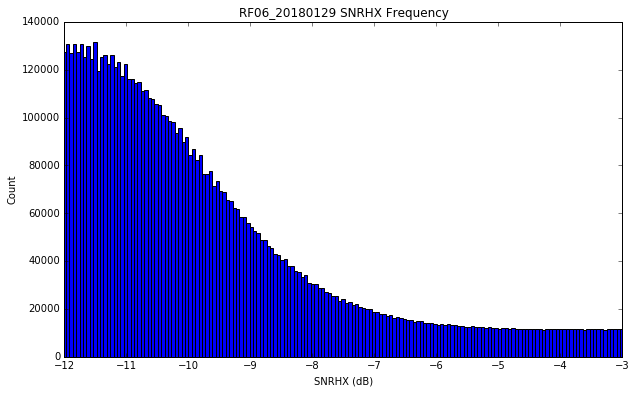

In [6]:
fig = plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(snrhx_masked,bins='auto')
plt.title('{} SNRHX Frequency'.format(flight))
plt.xlabel('SNRHX (dB)')
plt.ylabel('Count')
plt.xlim(-12, -3)
maxSNRHX = bins[np.argmax(n)]
print(maxSNRHX)

In [4]:
# dbmhx_masked = [p for p in dbmhx[:,26:].flatten() if np.isfinite(p)]

In [5]:
# n, bins, patches = plt.hist(dbmhx_masked,bins='auto')
# plt.xlim(-103, -100)
# maxDBMHX = bins[np.argmax(n)]
# print(maxDBMHX)

In [6]:
dbz_masked_ncp = np.ma.masked_where((ncp < 0.2)|(gateAlt < 0)|np.isinf(dbz)|np.isnan(dbz),dbz)
ldr_masked_inv0 = np.ma.masked_where((gateAlt < 0)|np.isinf(ldr)|np.isnan(ldr),ldr)
# ldr_masked_dbmhx = np.ma.masked_where((dbmhx < -101.0),ldr_masked_inv0)
ldr_masked_snrhx = np.ma.masked_where((snrhx < -6.0),ldr_masked_inv0)

In [7]:
startT_dt = dt.strptime(startT,'%Y%m%d_%H%M%S')
endT_dt = dt.strptime(endT,'%Y%m%d_%H%M%S')

tMatchStrt = min(time1d_rnd, key=lambda x: abs(pd.to_datetime(x) - startT_dt))
startT_ix = np.squeeze(np.where(time1d_rnd == tMatchStrt))[0]
tMatchEnd = min(time1d_rnd, key=lambda x: abs(pd.to_datetime(x) - endT_dt))
endT_ix = np.squeeze(np.where(time1d_rnd == tMatchEnd))[-1]

strtDT_rnd = pd.to_datetime(time1d_rnd[startT_ix])
endDT_rnd = pd.to_datetime(time1d_rnd[endT_ix])

	Plotting 20180119 - 04:30:00-04:45:00


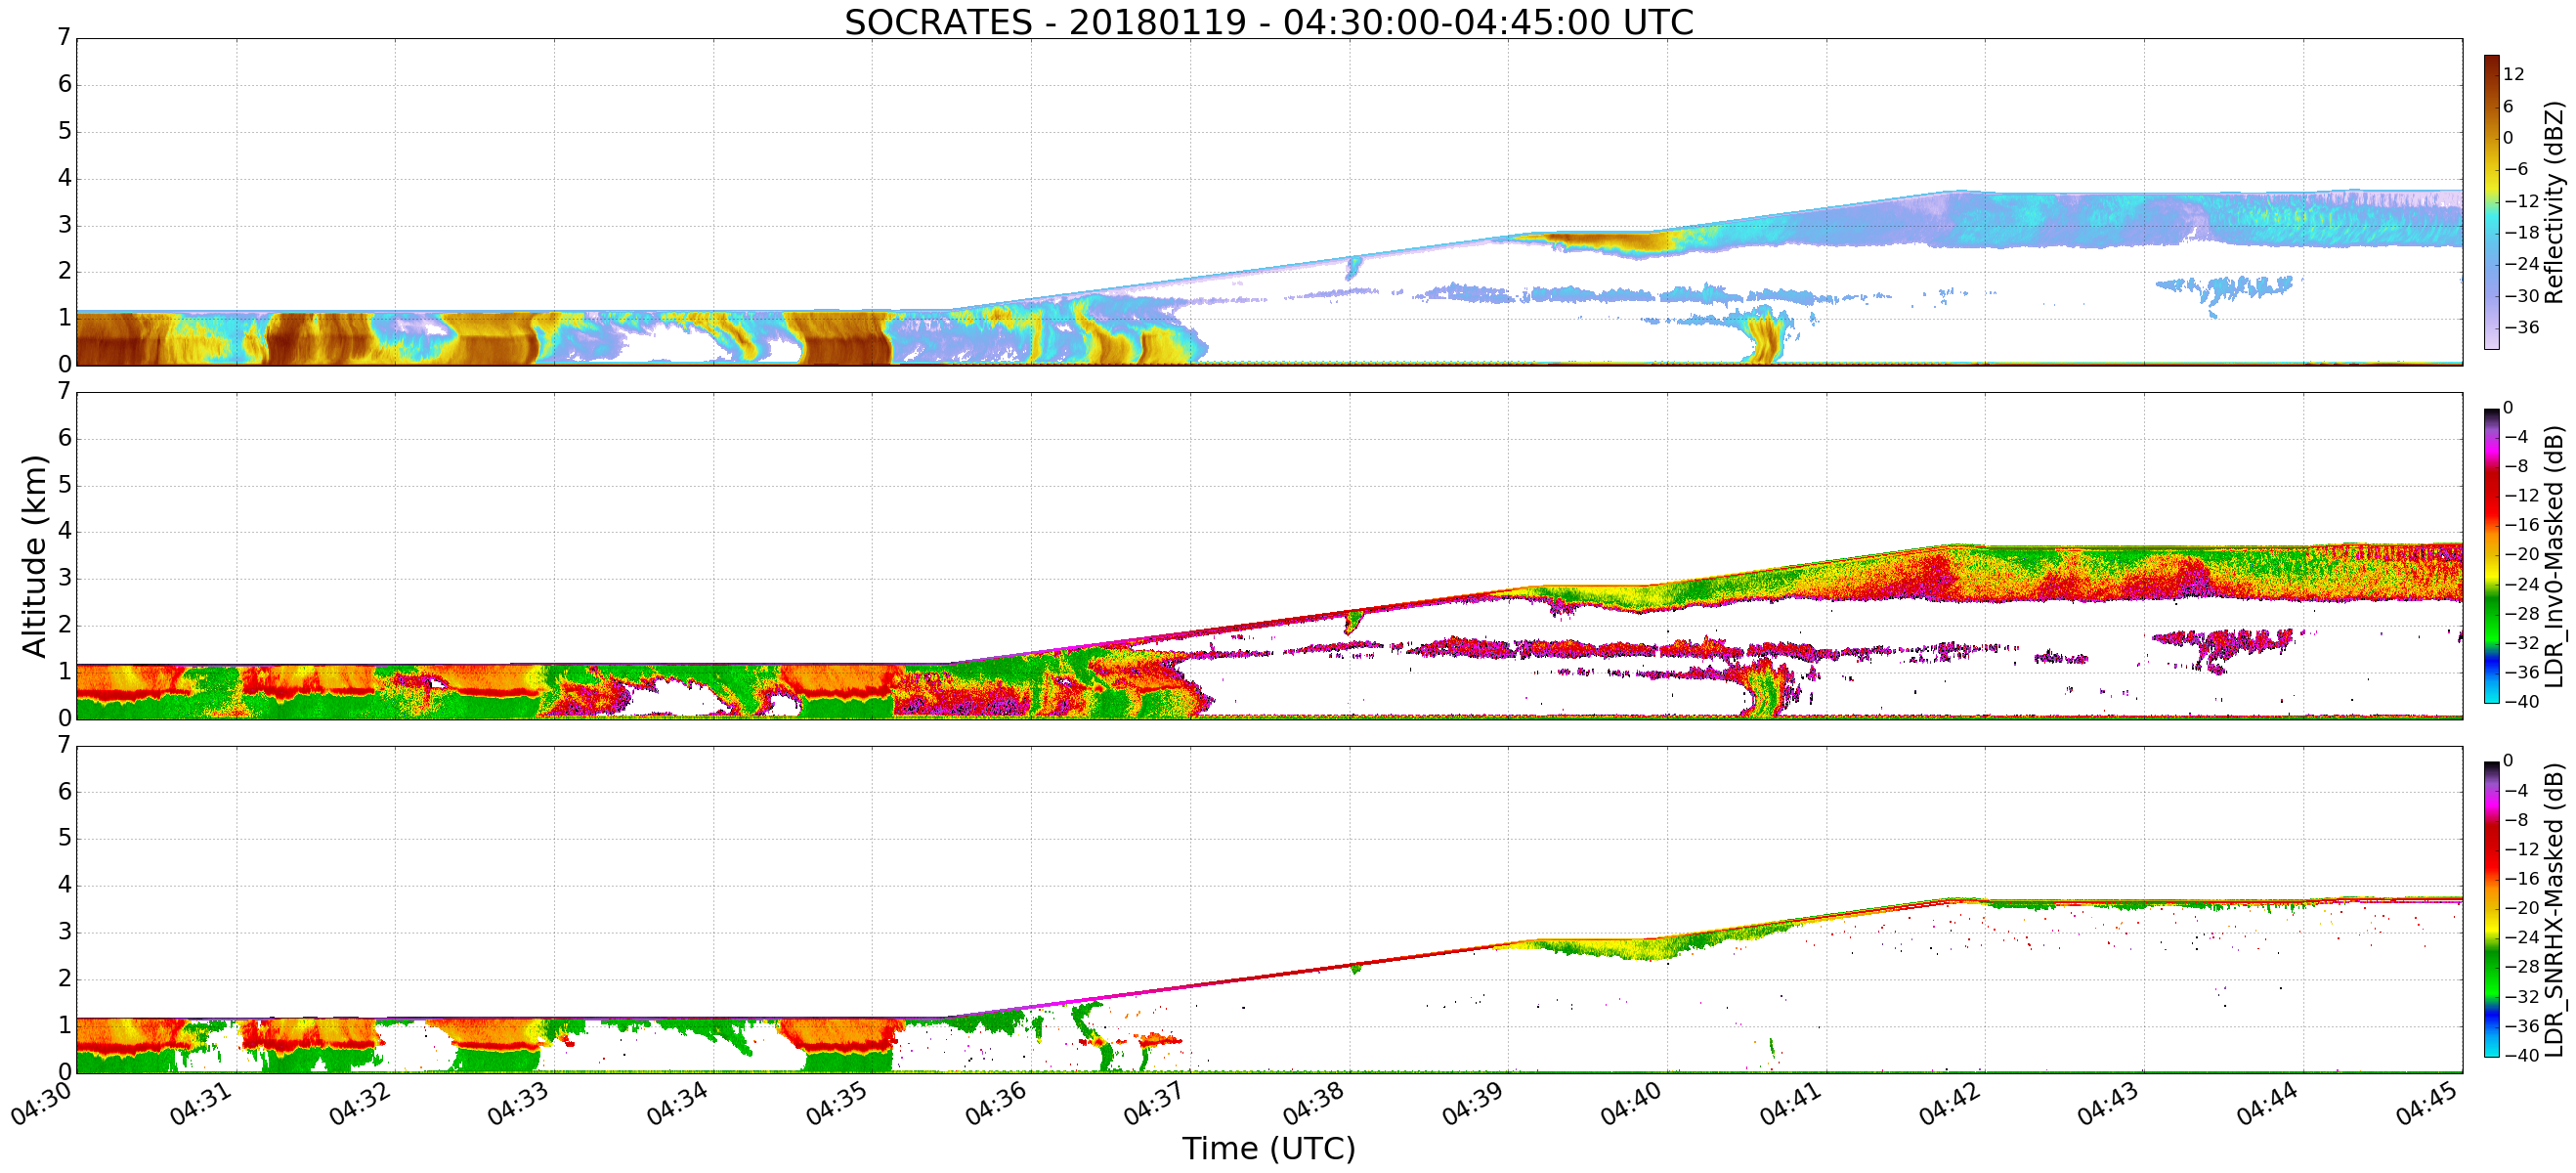

In [8]:
if strtDT_rnd.day == endDT_rnd.day:
    titleDTstr = '{} - {}-{}'.format(dt.strftime(strtDT_rnd,'%Y%m%d'),dt.strftime(strtDT_rnd,'%H:%M:%S'),
                                     dt.strftime(endDT_rnd,'%H:%M:%S'))
    saveDTstr = '{}_{}-{}'.format(dt.strftime(strtDT_rnd,'%Y%m%d'),dt.strftime(strtDT_rnd,'%H%M'),
                                     dt.strftime(endDT_rnd,'%H%M'))
else:
    titleDTstr = '{}-{} - {}-{}'.format(dt.strftime(strtDT_rnd,'%Y%m%d'),dt.strftime(strtDT_rnd,'%H:%M:%S'),
                                     dt.strftime(endDT_rnd,'%Y%m%d'),dt.strftime(endDT_rnd,'%H:%M:%S'))
    saveDTstr = '{}_{}-{}_{}'.format(dt.strftime(strtDT_rnd,'%Y%m%d'),dt.strftime(strtDT_rnd,'%H%M'),
                                     dt.strftime(endDT_rnd,'%Y%m%d'),dt.strftime(endDT_rnd,'%H%M'))

print('\tPlotting {}'.format(titleDTstr))

xtick_formatter = mdates.DateFormatter(fmt='%H:%M')

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(48,21))
axFsz = 32
caxFsz = 24
ttlFsz = 36
tkFsz = 24
ctkFsz = 18
caxShrnk = 0.9

titleAppnd = ''
saveAppnd = ''


im1 = ax1.pcolormesh(time2d[startT_ix:endT_ix,:],gateAlt[startT_ix:endT_ix,:]/1000,dbz_masked_ncp[startT_ix:endT_ix,:],
                     vmin=-40,vmax=16,cmap=pyart.graph.cm.LangRainbow12)
ax1.set_ylim([0,7])
cax1 = fig.colorbar(im1,ax=ax1,fraction=0.08,shrink=caxShrnk,pad=0.008)
cax1.set_label('Reflectivity (dBZ)',fontsize=caxFsz)
cax1.ax.set_yticklabels(cax1.ax.get_yticklabels(), fontsize=ctkFsz)
ax1.tick_params(axis='both', which='major', labelsize=tkFsz)
ax1.set_title('SOCRATES - {} UTC{}'.format(titleDTstr,titleAppnd),fontsize=ttlFsz) 
ax1.grid()


im2 = ax2.pcolormesh(time2d[startT_ix:endT_ix,:],gateAlt[startT_ix:endT_ix,:]/1000,ldr_masked_inv0[startT_ix:endT_ix,:],
                     vmin=-40,vmax=0,cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0,7])
cax2 = fig.colorbar(im2,ax=ax2,fraction=0.08,shrink=caxShrnk,pad=0.008)
cax2.ax.set_yticklabels(cax2.ax.get_yticklabels(), fontsize=ctkFsz)
cax2.set_label('LDR_Inv0-Masked (dB)',fontsize=caxFsz)
ax2.tick_params(axis='both', which='major', labelsize=tkFsz)
ax2.grid()
ax2.set_ylabel('Altitude (km)',fontsize=axFsz)

# im3 = ax3.pcolormesh(time2d[startT_ix:endT_ix,:],gateAlt[startT_ix:endT_ix,:]/1000,ldr_masked_dbmhx[startT_ix:endT_ix,:],
#                      vmin=-40,vmax=0,cmap=pyart.graph.cm.NWSRef)
# ax3.set_ylim([0,7])
# cax3 = fig.colorbar(im3,ax=ax3,fraction=0.08,shrink=caxShrnk,pad=0.008)
# cax3.ax.set_yticklabels(cax3.ax.get_yticklabels(), fontsize=ctkFsz)
# cax3.set_label('LDR_DBMHX-Masked (dB)',fontsize=caxFsz)
# ax3.tick_params(axis='both', which='major', labelsize=tkFsz)
# ax3.grid()
# ax3.set_xlabel('Time (UTC)',fontsize=axFsz)
# ax3.xaxis.set_major_locator(mdates.MinuteLocator())
# ax3.xaxis.set_major_formatter(xtick_formatter)

im3 = ax3.pcolormesh(time2d[startT_ix:endT_ix,:],gateAlt[startT_ix:endT_ix,:]/1000,ldr_masked_snrhx[startT_ix:endT_ix,:],
                     vmin=-40,vmax=0,cmap=pyart.graph.cm.NWSRef)
ax3.set_ylim([0,7])
cax3 = fig.colorbar(im3,ax=ax3,fraction=0.08,shrink=caxShrnk,pad=0.008)
cax3.ax.set_yticklabels(cax3.ax.get_yticklabels(), fontsize=ctkFsz)
cax3.set_label('LDR_SNRHX-Masked (dB)',fontsize=caxFsz)
ax3.tick_params(axis='both', which='major', labelsize=tkFsz)
ax3.grid()
ax3.set_xlabel('Time (UTC)',fontsize=axFsz)
ax3.xaxis.set_major_locator(mdates.MinuteLocator())
ax3.xaxis.set_major_formatter(xtick_formatter)


fig.autofmt_xdate()
fig.subplots_adjust(hspace=0.08)

# saveStr = '{}HCR-ldrNoiseThresh_{}{}.{}'.format(figSavePath,saveDTstr,saveAppnd,fType)
# fig.savefig(saveStr,bbox_inches='tight')